In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu0"
os.environ["CPATH"] = ""
import numpy as np

from collections import OrderedDict
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import BatchIterator, get_batch_slice


from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.fonts import Fonts
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.datasets.dtd import DTD
from lasagnekit.datasets.cached import Cached
from lasagnekit.datasets.faces import Faces
from lasagnekit.datasets.cifar100 import Cifar100

from lasagnekit.misc.plot_weights import grid_plot
from lasagne import layers, updates
from IPython.display import SVG

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


srng = RandomStreams(seed=234)


from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform, Constant
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from utils import TransposedConv2DLayer, Conv2DDenseLayer, TransposedDenseLayer, SampleOutLayer

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
seed = 1234
np.random.seed(seed)
rng = RandomStreams(seed)

In [122]:
# choose between mnist and fonts
dataset = "mnist"
w, h = 32, 32 # Desired resolution, not necessarely the same than real_w and real_h, 
              # if necessary the images will be resize to fit w and h)

In [146]:
if dataset == "mnist":
    data = MNIST()
elif dataset == "fonts":
    data = Fonts(kind="all_64", 
                 labels_kind="letters")
elif dataset == "textures":
    data = DTD(examples_filter=np.arange(2000))
    data.load()
elif dataset == "cifar":
    data = Cifar100()
    
data_rescaled = Cached(Rescaled(data, size=(w, h)))
data_rescaled.load()
X = data_rescaled.X
if hasattr(data_rescaled, "y"):
    y = data_rescaled.y
else:
    y = np.ones((X.shape[0],))

In [147]:
if len(data_rescaled.img_dim) == 3:
    nb_colors = data_rescaled.img_dim[0]
else:
    nb_colors = 1 # gray

In [148]:
extract_patches = False
if extract_patches:
    from sklearn.feature_extraction.image import PatchExtractor
    w, h = 12, 12
    extractor = PatchExtractor(max_patches=100, patch_size=(w, h))
    patches = extractor.transform(X.reshape((X.shape[0], nb_colors, w, h)).transpose((0, 2, 3, 1)))
    patches = patches.transpose((0, 3, 1, 2))
    X = patches.astype(np.float32)
    y = np.ones((X.shape[0]))


In [149]:
print(X.shape, y.shape,)
flat_shape = X.shape

((60000, 3072), (60000,))


In [150]:
standardize=True
if standardize is True:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    def preprocess(X):
        return scaler.transform(X.reshape((X.shape[0], -1)))
    def deprocess(X_p):
        return scaler.inverse_transform(X_p).reshape((X_p.shape[0], nb_colors, w, h))
else:
    def preprocess(X):
        return X
    def deprocess(X_p):
        return X_p

In [221]:
def preprocess(X):
        return scaler.transform(X.reshape((X.shape[0], -1)))
def deprocess(X_p):
        return scaler.inverse_transform(X_p.reshape(X_p.shape[0], -1)).reshape((X_p.shape[0], nb_colors, w, h))

In [151]:
X = X.reshape((X.shape[0], nb_colors, w, h))
image_shape = X.shape

In [152]:
zca = False
if zca is True:
    assert standardize is True
    zca = ZCA()
    X = zca.fit_transform(X.reshape((X.shape[0], -1))).reshape(X.shape).astype(np.float32)

In [153]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

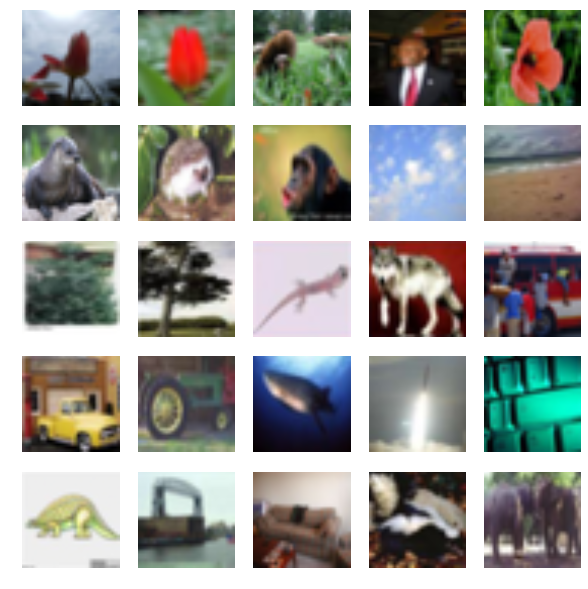

In [154]:
input_images = scaler.inverse_transform(X.reshape(flat_shape)).reshape(image_shape)
input_images_ = input_images.transpose((0, 2, 3, 1))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n, n
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

# Model

In [155]:
class Model(object):
    def __init__(self):
        self.extra_params = []
    def get_all_params(self, **kwargs):
        return (list(set(self.x_to_z.get_all_params(**kwargs) + 
                        self.z_to_x.get_all_params(**kwargs)))+self.extra_params)

In [156]:
model_type = "fully_connected"

In [227]:
from lasagne import init
def quantile_standard(p=0.5):
    return np.sqrt(2) * T.erfinv(2*p-1)

def quantile(x, p=0.5, axis=None):
    return x.mean(axis=axis) + x.std(axis=axis) * quantile_standard(p)

def thresh_for(x, keep=100):
    return T.addbroadcast((T.sort(x, axis=1)[:, -keep:-keep+1]), 1)

if model_type == "fully_connected":
    ## fully connected
    latent_size = 2000
    keep = theano.shared(np.array(70))
    
    l_in = layers.InputLayer((None, nb_colors, w, h), name="input")
    l_pre_latent = layers.DenseLayer(l_in, 
                                 num_units=latent_size,
                                 name="latent",
                                 #W=init.Normal(std=0.01),
                                 #W=init.Uniform(range=0.01),
                                 W=init.Uniform(range=0.27),
                                 #nonlinearity=T.nnet.sigmoid,
                                 #nonlinearity=rectify,
                                 nonlinearity=None,
                                 #nonlinearity=lambda x:rectify(x+thresh)* (x/(x+thresh)),
                                 #b=Constant(0.),
                                 b=None
                                 )
    l_latent = layers.NonLinearityLayer(l_latent, 
                                        lambda x: (x>   thresh_for(x, keep=keep)  )*x)
    l_decoder_out = TransposedDenseLayer(l_latent, num_units=nb_colors*w*h,
                                         W=l_latent.W,
                                         #W=init.Uniform(range=0.2734344),
                                         b=Constant(0.),
                                         nonlinearity=None)
    l_decoder_out_reshaped = layers.ReshapeLayer(l_decoder_out, ([0], nb_colors, w, h))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out_reshaped])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    #model.extra_params.append(thresh)

In [228]:
def show_filters(all_layers, shuffled=True, nbrows=10, nbcols=10, scaler=None):
    fig = plt.figure(figsize=(10, 10))
    V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
    V = V.T
    if scaler is not None:
        V = scaler.inverse_transform(V)
    V = V.reshape((-1, nb_colors, w, h))
    #min_val = V.min(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    #max_val = V.max(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    min_val = V.min(axis=0)
    max_val = V.max(axis=0)
    V = (V - min_val) / (max_val - min_val)

    V = V.transpose((0, 2, 3, 1)) 
    V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
    s = np.arange(V_.shape[0])
    np.random.shuffle(s)
    grid_plot(V_[s, :, :], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
    plt.show()

In [229]:
if model_type == "convnet":
    filter_size = 5
    latent_size = 50
    num_filters = 64
    
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, 
                                filter_size=(filter_size, filter_size),
                                name="conv1")
    l_conv_2 = layers.Conv2DLayer(l_conv, num_filters=num_filters, 
                                  filter_size=(filter_size, filter_size),
                                  name="conv2")
    sw = w - 2 * filter_size + 2
    l_latent = Conv2DDenseLayer(l_conv_2, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    
    l_unconv_2 = layers.Conv2DLayer(l_un_latent, num_filters=num_filters, 
                                   filter_size=(filter_size, filter_size),
                                   pad="full",
                                   name="unconv_2")
    l_unconv = layers.Conv2DLayer(l_unconv_2, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  pad="full",
                                  name="unconv_1")

    l_decoder_out = l_unconv
    
    """
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, filter_size=(filter_size, filter_size), name="conv1")
    
    l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2), name="pool1")
    #l_pool = l_conv
    
    # sw = (w - filter_size + 1)
    sw = (w - filter_size + 1) / 2

    l_latent = Conv2DDenseLayer(l_pool, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    l_unpool = layers.Upscale2DLayer(l_un_latent, 2, name="unpool1")
    #l_unpool = l_un_latent
    l_unconv = layers.Conv2DLayer(l_unpool, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  #W=l_conv.W,
                                  name="unconv1",
                                  pad='full',
                                  nonlinearity=None)
    l_decoder_out = l_unconv
    """
    print(layers.get_output_shape(l_decoder_out, (100, 3, 28, 28)))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    
    
    def show_filters(all_layers, shuffle=True, nbrows=10, nbcols=10):
        
        fig = plt.figure(figsize=(10, 10))
        V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
        V = V.transpose((0, 2, 3, 1)) 
        min_val = V.min(axis=(1, 2, 3))[:, None, None, None]
        max_val = V.max(axis=(1, 2, 3))[:, None, None, None]
        V = (V - min_val) / (max_val - min_val)
        V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
        s = np.arange(V_.shape[0])
        if shuffle is True:
            np.random.shuffle(s)
        grid_plot(V_[s], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
        plt.show()

In [230]:
layers_by_name = OrderedDict()


all_layers = (
    layers.get_all_layers(model.x_to_z.output_layers[0]) +
    layers.get_all_layers(model.z_to_x.output_layers[0])
)

for l in all_layers:
    if l.name is not None:
        layers_by_name[l.name] = l
print(layers_by_name.keys())

['input', 'latent']


## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [231]:
input_variables = OrderedDict()
input_variables["input_image"] = dict(tensor_type=T.tensor4)

In [316]:
def loss_function(model, tensors, noise=False):
    input_image = tensors["input_image"]    
    input_image_old = input_image
    #noisify
    if noise is True:
        print(noise)
        #input_image = input_image * (rng.uniform(size=input_image.shape) <= 0.7)
        input_image = input_image + rng.normal(std=0.01, size=input_image.shape)
    output = get_output(model, input_image)    
    
    lat
    recons = ((input_image_old - output) ** 2)
    #recons = (input_image_old * T.nnet.softplus(-output) + (1 - input_image_old) * T.nnet.softplus(output))
    recons = recons.sum(axis=(1, 2, 3))
    return recons.mean()

def get_latent(model, input_image):
    z, = model.x_to_z.get_output(input_image)
    return z

def get_output(model, input_image):
    z = get_latent(model, input_image)
    o, = model.z_to_x.get_output(z)
    return o

def get_output_from_latent(model, latent):
    o, = model.z_to_x.get_output(latent)
    return o

def get_loss(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=True)

def get_loss_deterministic(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=False)

functions = dict(
    get_output=dict(
        get_output=get_output,
        params=["input_image"]
    ),   
    get_latent=dict(
        get_output=get_latent,
        params=["input_image"]
    ),
    get_loss=dict(
        get_output=get_loss,
        params=["input_image"]
    ),
    get_loss_deterministic=dict(
        get_output=get_loss_deterministic,
        params=["input_image"]
    )
  
)

class MyBatchOptimizer(BatchOptimizer):
    # called for each epoch during training
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        nb = 200
        status["train_loss"] = self.model.get_loss_deterministic(X[train][0:nb])
        status["test_loss"] = self.model.get_loss_deterministic(X[test][0:nb])

        if (status["epoch"] % 10) == 0:
            show_filters(all_layers, scaler=scaler)
        keep.set_value( max(keep.get_value()-1, 40)  )
        return status

In [343]:
#re-init
#l_latent.W.set_value(init.Normal(std=0.01)(l_latent.W.get_value().shape))
l_latent.W.set_value(init.Orthogonal()(l_latent.W.get_value().shape))
from scipy.ndimage.filters import laplace, gaussian_filter
#shape = l_latent.W.get_value().shape
#val=(gaussian_filter(np.random.uniform(-0.01, 0.01, size=(shape[1], nb_colors, w, h)), 0.1).T.reshape(shape))
#val=val.astype(np.float32)
#l_latent.W.set_value(val)
l_decoder_out.b.set_value(init.Constant(0.)(l_decoder_out.b.get_value().shape))
keep.set_value(40)

In [344]:
batch_optimizer = MyBatchOptimizer(
    max_nb_epochs=200,
    verbose=1,
    batch_size=128,
    #optimization_procedure=(updates.adam, {"learning_rate": 0.001})
    #optimization_procedure=(updates.nesterov_momentum, {"learning_rate": 0.0001, "momentum": 0.5})
    optimization_procedure=(updates.rmsprop, {"learning_rate": 0.0001})
)

In [345]:
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)

True


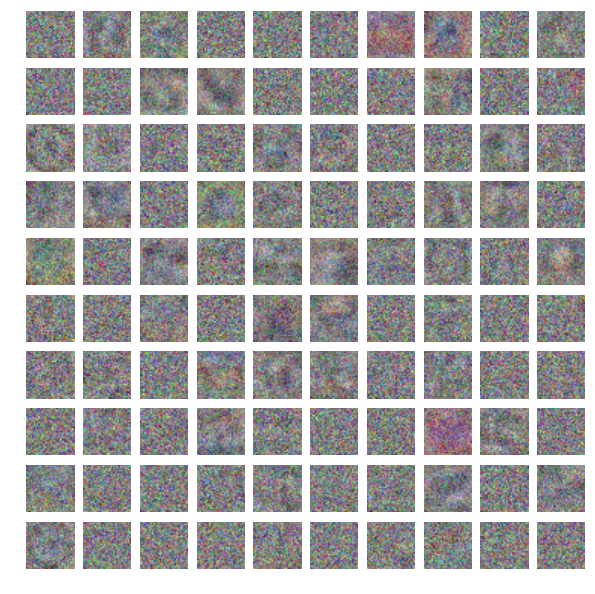

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      0     386.415       1345.56       983.599      999.403
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      1     77.8982       815.998       740.507      758.383
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      2     43.2601        657.04       635.813      653.508
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      3     31.3434       581.805       579.977       602.95
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      4     26.8302       540.594       545.436      576.288
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

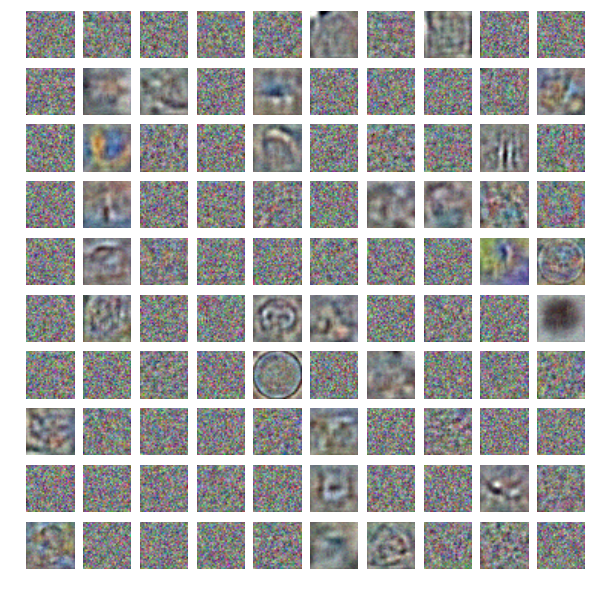

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     10     21.0476       452.946       464.536      502.304
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     11     20.7936       447.086       458.291      496.461
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     12      20.539       442.042       452.373      492.523
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     13      20.387       437.679       447.507      489.638
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     14     20.1916       433.644       443.907      486.008
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

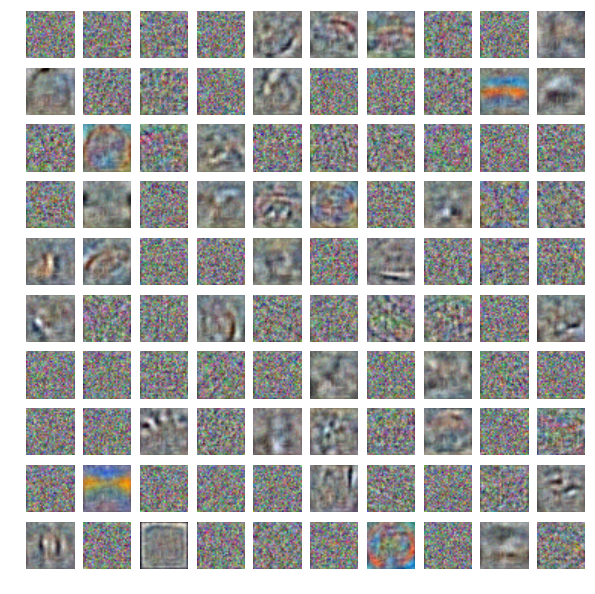

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     20     19.1163       414.829        424.12      469.612
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     21     19.0069       412.232       421.593      467.973
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     22     18.8679       409.824       418.731      466.507
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     23      18.772       407.558       416.865      463.991
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     24     18.7056         405.4       414.339      462.592
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

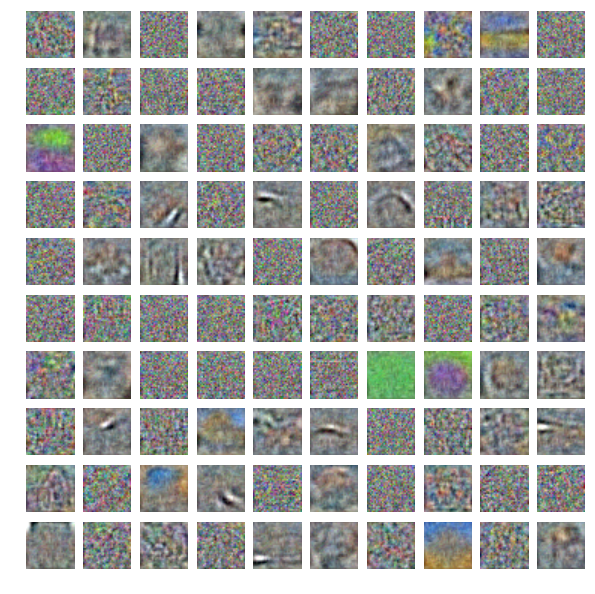

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     30     18.2206       394.783       401.115      455.569
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     31     18.0839       393.202       399.356      454.804
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     32     17.9199       391.318       397.168      453.313
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     33     17.8418       389.855       395.729      453.134
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     34     17.8505       388.556       394.108      452.125
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

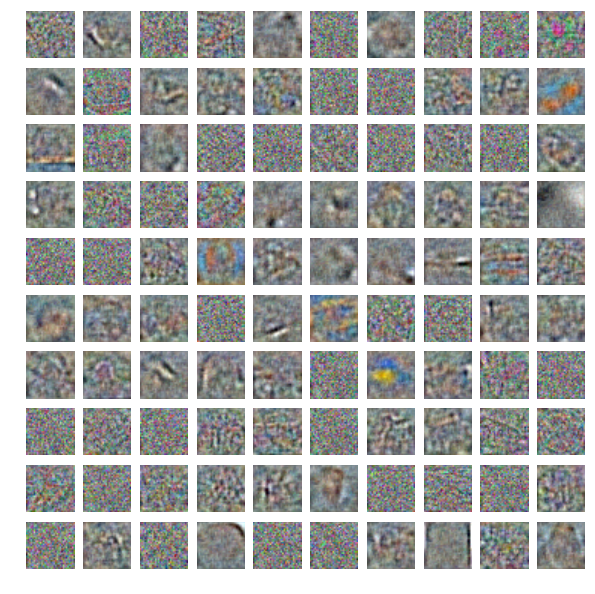

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     40      17.603       382.009       388.322      447.735
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     41     17.4542       381.052       387.749      447.541
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     42     17.3544       380.114       387.149       447.49
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     43      17.316       379.309       386.576      447.612
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     44     17.3039       378.498       385.382       447.43
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

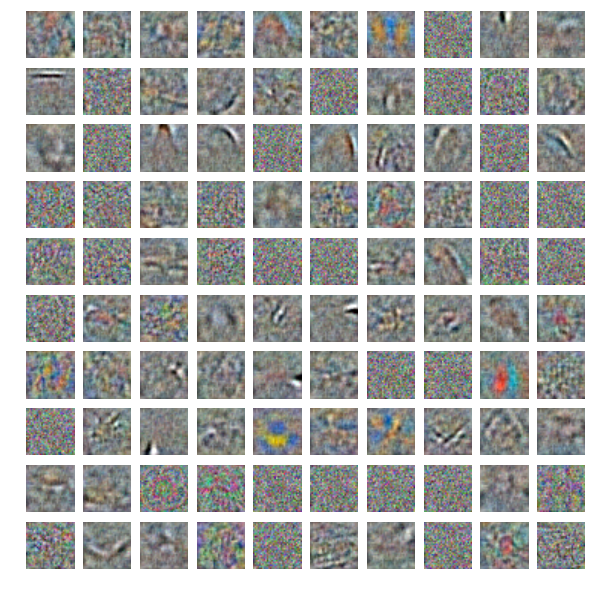

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     50     16.9713       374.444       381.527      446.291
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     51     16.9831       373.883       381.635      446.137
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     52     16.9063       373.323       380.641       446.47
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     53     16.8961       372.806       380.643      446.172
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     54       16.85       372.317       380.188      445.213
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

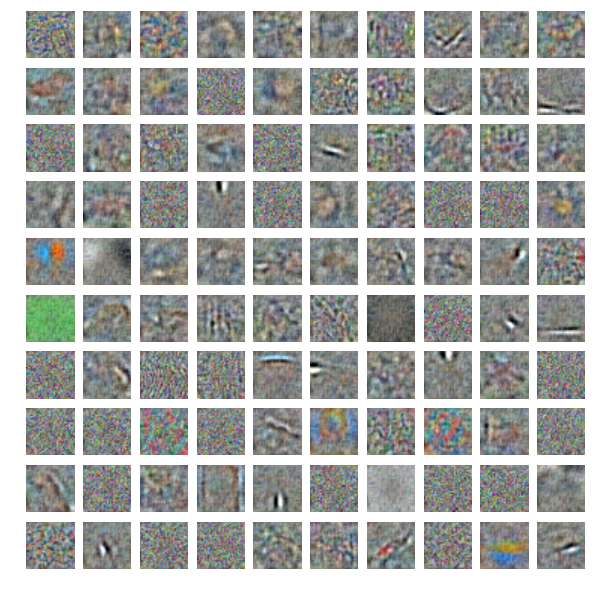

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     60     16.7275       368.577        376.81      441.136
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     61     16.7283       368.083       376.564      440.295
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     62     16.7508       367.713       376.444      438.968
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     63      16.743       367.336       376.425      438.571
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     64     16.6844       367.018       375.851      438.169
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

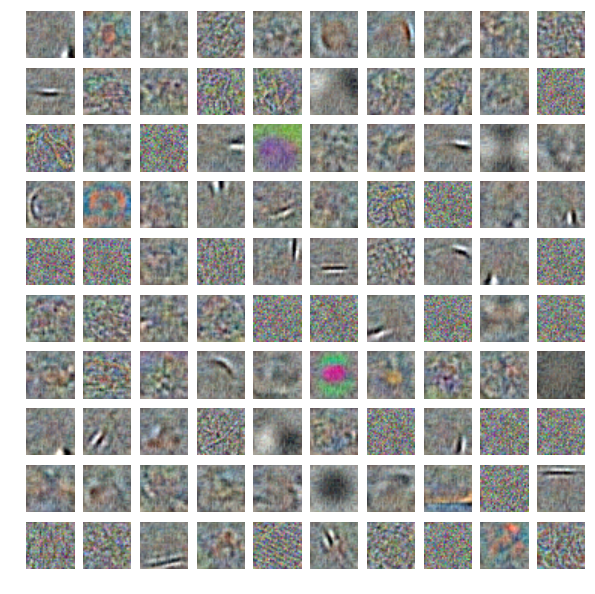

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     70     16.5887       365.124        373.77       439.12
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     71     16.5327        364.92       374.147      439.097
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     72     16.5838        364.68        373.86      437.931
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     73     16.6199       364.415       373.832      437.763
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     74     16.5651       364.232       374.052      437.342
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

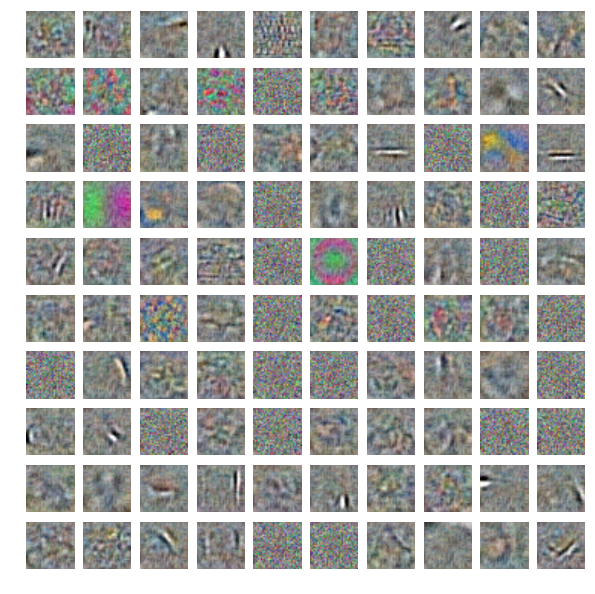

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     80     16.4591       363.134       373.673      437.525
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     81     16.4897       362.958       373.523      437.681
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     82     16.4315       362.838       373.033      438.002
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     83     16.4208        362.64       372.745      438.322
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     84     16.4186       362.511       372.107      438.229
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

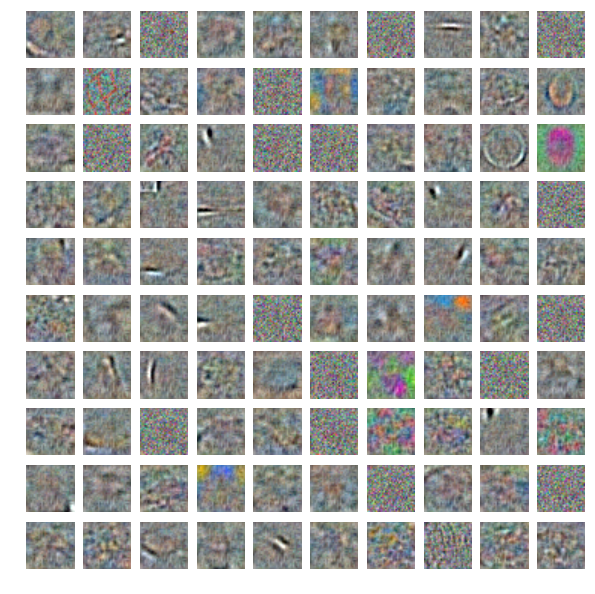

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     90     16.4526       361.736       371.917      438.788
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     91     16.4682       361.636       371.965      438.488
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     92     16.4744       361.547       372.137      438.722


KeyboardInterrupt: 

In [346]:
%%time
capsule.fit(input_image=X[train])

## checking performance

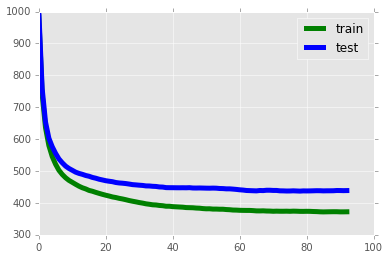

In [347]:
from lasagnekit.easy import get_stat
plt.plot(get_stat("train_loss", batch_optimizer.stats), c='g', label="train", linewidth=5)
plt.plot(get_stat("test_loss", batch_optimizer.stats), c='b', label="test", linewidth=5)
plt.legend()
plt.show()

In [348]:
input_images = X
input_images = input_images[np.random.randint(0, input_images.shape[0], size=150)]
output_images = capsule.get_output(input_images)

In [349]:
print(input_images.shape)

(150, 3, 32, 32)


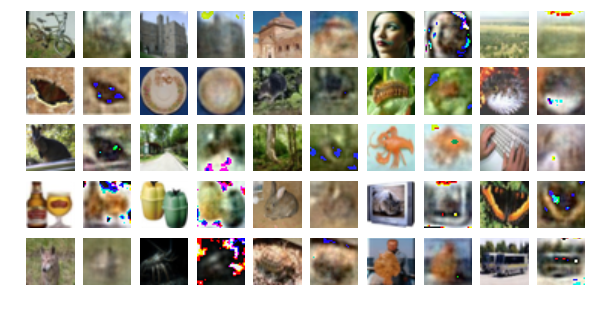

In [350]:
input_images_ = deprocess(input_images).transpose((0, 2, 3, 1))

def a(x):
    return x
    return 1./(1.+np.exp(-x))
output_images_ = a(deprocess(output_images).transpose((0, 2, 3, 1)))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
if output_images_.shape[-1] == 1:
    output_images_ = output_images_[:, :, :, 0]

input_images_ = input_images_[0:n**2]
fig = plt.figure(figsize=(10, 10))
n = 5

gridw, gridh = n*2, n*2
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(output_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

## Apply blending

In [223]:
#!wget http://i.imgur.com/2HVJF0t.gif --output-document=image.gif
#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/cheval%201/images/chevaux_1_015.gif --output-document=image.gif

!wget http://i.imgur.com/iqZBF6A.jpg --output-document=image.jpg # im1
#!wget http://jmg.j.m.pic.centerblog.net/it3ahbzg.jpg --output-document=image.jpg #im2
#!wget http://jmg.j.m.pic.centerblog.net/c4j703bp.jpg --output-document=image.jpg #im3
#!wget http://www.freelargeimages.com/wp-content/uploads/2014/12/Landscape_01.jpg --output-document=image.jpg # im4

#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/chevaux%205/images/chevaux_5_008.gif --output-document=image.gif
#!wget http://www2.mes-coloriages-preferes.biz/colorino/Images/Large/Animaux-Cheval-3756.png --output-document=image.gif
#!wget https://sustainability.uic.edu/files/2013/11/Tree.jpg --output-document=image.jpg --no-check-certificate
#!wget http://www.vbctulsa.com/wordpress/wp-content/uploads/2015/02/wrackthetree.jpg --output-document=image.jpg

--2015-10-19 03:41:09--  http://i.imgur.com/iqZBF6A.jpg
Resolving i.imgur.com... 185.31.18.193
Connecting to i.imgur.com|185.31.18.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727023 (710K) [image/jpeg]
Saving to: “image.jpg”

100%[======================================>] 727,023     --.-K/s   in 0.06s   

2015-10-19 03:41:10 (12.5 MB/s) - “image.jpg” saved [727023/727023]



In [224]:
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
image = (imread("image.jpg"))
print(image.shape)
image = resize(image, (256, 256))
#image = image[:, :, 0] # RGB?
#print(image)
image = 1 - image
if len(image.shape) == 2:
    image = image[:, :, None] * np.ones((1, 1, nb_colors))
print(image.shape)

(1836, 3264, 3)
(256, 256, 3)


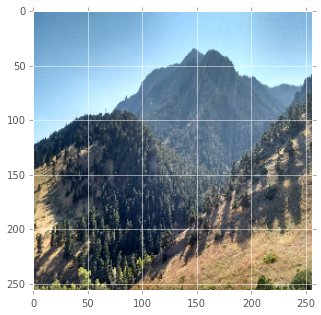

In [225]:
fig = plt.figure(figsize=(5, 5))
im = image[:, :, 0] if nb_colors == 1 else image
orig_im = im.copy()
plt.imshow(1-im, cmap="gray")

In [226]:
image_ = (image.transpose((2, 0, 1)).astype(np.float32))[None, :, :, :].copy()
image_ = preprocess(image_)
print(image_.shape)
for i in range(1):
    image_ = capsule.get_output(image_)
image_ = deprocess(image_)
image__ = image_.transpose((0, 2, 3, 1))

im = image__[0, :, :, 0] if nb_colors == 1 else image__[0]

alpha=0.03
im = (im - im.min()) / (im.max() - im.min())
fig = plt.figure(figsize=(5, 5))
plt.imshow( (1-im), cmap="gray")

(1, 3, 256, 256)


ValueError: dimension mismatch in args to gemm (1,196608)x(3072,1000)->(1,1000)
Apply node that caused the error: GpuDot22(GpuFlatten{2}.0, latent.W)
Toposort index: 9
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(1, 196608), (3072, 1000)]
Inputs strides: [(0, 1), (1000, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[HostFromGpu(GpuDot22.0), GpuElemwise{Composite{Cast{float32}(GT(i0, i1))},no_inplace}(GpuDot22.0, GpuFromHost.0), GpuElemwise{Mul}[(0, 0)](GpuElemwise{Composite{Cast{float32}(GT(i0, i1))},no_inplace}.0, GpuDot22.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## weights

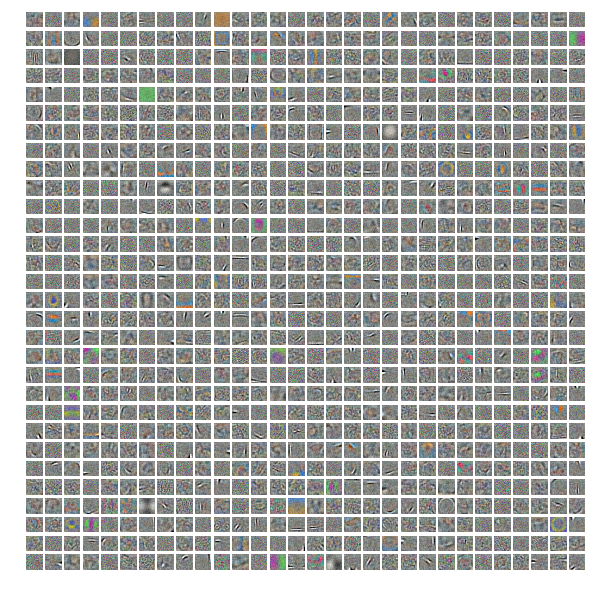

In [351]:
show_filters(all_layers, nbrows=30, nbcols=30)